# 학종이만한 사진을 크게 늘리기

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [2]:
import imageio
x = imageio.imread('./dataset/training/00001.png')

In [3]:
x.shape

(800, 600, 3)

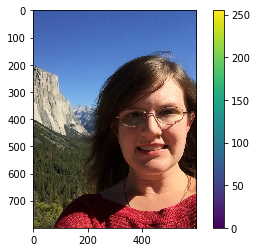

In [4]:
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
# x를 각각 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.

from skimage.transform import resize

x1 = resize(x,(100, 75))
x1.shape

(100, 75, 3)

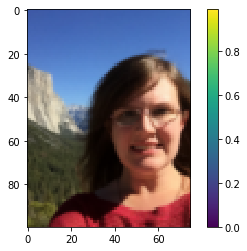

In [6]:
plt.imshow(x1)
plt.colorbar()

In [7]:
# x를 각각 (800, 600, 3) -> (50, 37, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.

x2 = resize(x1,(50, 37))
x2.shape

(50, 37, 3)

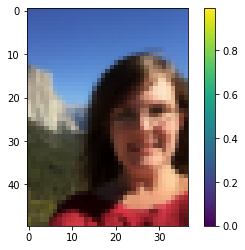

In [8]:
plt.imshow(x2)
plt.colorbar()

In [10]:
pfcn_small = np.load('./pfcn_small.npz')

In [11]:
list(pfcn_small.keys())

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [12]:
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

In [14]:
# train_big_images, test_big_images를 (50, 37, 3)으로 축소하고 train_small_images / test_small_images의 이름으로 할당하세요.

train_small_images = np.array([resize(i,(50, 37)) for i in train_big_images])
train_small_images.shape

(1700, 50, 37, 3)

In [15]:
test_small_images = np.array([resize(i,(50, 37)) for i in test_big_images])
test_small_images.shape

(300, 50, 37, 3)

In [16]:
train_big_images.dtype

dtype('float64')

## * 데이터 전처리 *

In [17]:
# train/test 전체 데이터에서 각 images의 min, max를 출력하는 코드를 작성하세요.

print(train_big_images.max())
print(train_big_images.min())

1.0
0.0


In [18]:
# (배치, 100, 75, 3)인 train_big_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.

train_big_images[:5].shape

(5, 100, 75, 3)

In [20]:
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요. (375= 5*75)
# (5,100,75,3) -> transpose: (100,5,75,3) -> reshape: (100,5*75=375,3)

train_big_images[:5].transpose(1,0,2,3).reshape((100,-1,3)).shape

(100, 375, 3)

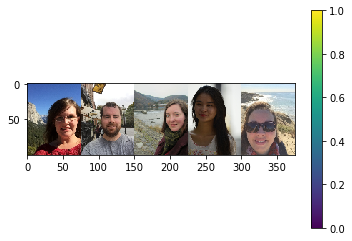

In [21]:
# (100, 375, 3)의 이미지를 plt로 출력해보세요.

plt.imshow(train_big_images[:5].transpose(1,0,2,3).reshape((100,-1,3)))
plt.colorbar()

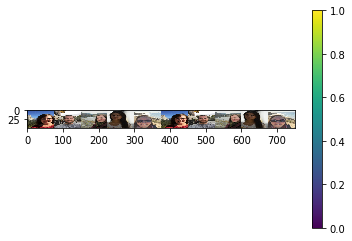

In [22]:
# (50, 37 * 5, 3)의 이미지를 plt로 출력해보세요.

plt.imshow(train_big_images[:5].transpose(1,0,2,3).reshape((50,-1,3)))
plt.colorbar()

## * 모델 생성 (U-Net) *

In [23]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Dropout, Activation, concatenate

In [27]:
# Conv2D
# BatchNormalization
# Activation
# Conv2D
# BatchNormalization
# Activation

def conv2d_block(x,channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [28]:
def unet_resoultion():
    inputs = Input((50, 37, 3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)
    
    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = conv2d_block(u6, 128)
    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0,1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = conv2d_block(u7, 64)
    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1,0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = conv2d_block(u8, 32)
    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = conv2d_block(u9, 16)
    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c9)
    
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)
    
    model = Model(inputs, outputs)
    
    return model

In [29]:
model = unet_resoultion()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 37, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 37, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 37, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [30]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [31]:
hist = model.fit(train_small_images, train_big_images, validation_data=(test_small_images, test_big_images), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 18s 294ms/step - loss: 0.1905 - accuracy: 0.4364 - val_loss: 0.2262 - val_accuracy: 0.2870
Epoch 2/25
54/54 [==============================] - 16s 288ms/step - loss: 0.0852 - accuracy: 0.5872 - val_loss: 0.1836 - val_accuracy: 0.6856
Epoch 3/25
54/54 [==============================] - 15s 271ms/step - loss: 0.0668 - accuracy: 0.7481 - val_loss: 0.1531 - val_accuracy: 0.7275
Epoch 4/25
54/54 [==============================] - 15s 270ms/step - loss: 0.0632 - accuracy: 0.7713 - val_loss: 0.1360 - val_accuracy: 0.7455
Epoch 5/25
54/54 [==============================] - 15s 271ms/step - loss: 0.0608 - accuracy: 0.7749 - val_loss: 0.1172 - val_accuracy: 0.7373
Epoch 6/25
54/54 [==============================] - 15s 272ms/step - loss: 0.0592 - accuracy: 0.7823 - val_loss: 0.0816 - val_accuracy: 0.7106
Epoch 7/25
54/54 [==============================] - 15s 270ms/step - loss: 0.0575 - accuracy: 0.7827 - val_loss: 0.0793 - val_accuracy: 0.7559

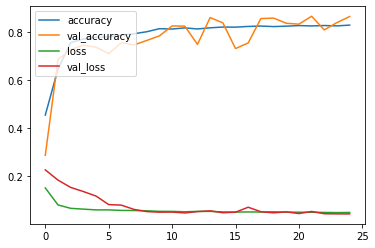

In [32]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## * 모델 예측 *

In [33]:
res = model.predict(test_small_images[1:2])
res.shape, test_small_images[:1].shape  # 예측한 shape, test한 shape

((1, 100, 75, 3), (1, 50, 37, 3))

In [34]:
# test_small_images[1]을 resize 함수를 이용해여 (100, 75, 3) 으로 2배 확대하는 코드를 작성하세요.

exp = resize(test_small_images[1], (100, 75))
exp.shape

(100, 75, 3)

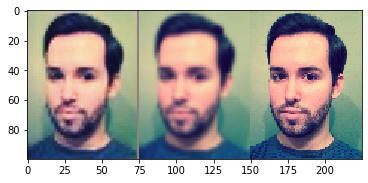

In [35]:
# res와 확대한 이미지, test_big_images[1]]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.

# 1. 예측한 사진(unet이란 모델을 써서 선명도가 올라간 사진, res[0]), 
# 2. 작게 만든 사진을 확대한 사진(exp)
# 3. 원본 사진(test_big_images[1])

imgs = np.concatenate([res[0], exp, test_big_images[1]], axis=1)
plt.imshow(imgs)

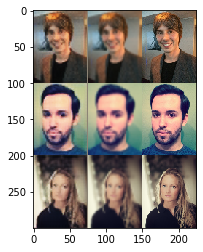

In [39]:
# 3장의 이미지를 모델에 넣고 결과를 비교하는 코드를 작성하세요

result = model.predict(test_small_images[:3])
exps = np.array([resize(img,(100,75)) for img in test_small_images[:3]])
imgs = np.concatenate([result, exps, test_big_images[:3]], axis=2).reshape((300,-1,3))

plt.imshow(imgs)

## * 평가*

In [40]:
infor = model.evaluate(test_small_images, test_big_images)
print(infor)

10/10 [==============================] - 1s 57ms/step - loss: 0.0427 - accuracy: 0.8650
[0.04274697229266167, 0.8650453090667725]


## * (cf) 모델 저장 및 불러오기 *

In [41]:
# 만든 모델 저장

model.save('./lec07.h5')

In [ ]:
# 만든 모델 로드(불러오기)

tf.keras.load_model('./lec07.h5')